In [ ]:
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.4/129.4 KB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 KB 12.2 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

In [ ]:
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#https://snyk.io/advisor/python/yfinance/functions/yfinance.pdr_override
yf.pdr_override()

In [ ]:
sectors =["consumer defensive","consumer goods","financial services","healthcare","industrials","basic materials","telecommunication","real estate"]

consumer_defensive=["SZU.DE","B4B3.DE"]
consumer_goods=["BOSS.DE","HLE.DE","PUM.DE","ZAL.DE","SHA.DE","CEC.DE"] 
financial_services=["TLX.DE","HNR1.DE","ARL.DE","PBB.DE"]
healthcare=["FIE.DE","EVT.DE","GXI.DE"] 
industrials=["MTX.DE","NDA.DE","RHM.DE","DUE.DE","FRA.DE","NOEJ.DE","KGX.DE","JUN3.DE","G1A.DE","AIR.DE","HOT.DE","LEO.DE","KRN.DE"] 
basic_materials=["WCH.DE","BNR.DE","LXS.DE","EVK.DE","SDF.DE","FPE3.DE","SZG.DE","SY1.DE","1COV.DE"]
telecommunication=["SAX.DE","RRTL.DE"] 
real_estate=["TEG.DE","DEQ.DE","G24.DE","DWNI.DE","LEG.DE","GYC.DE"]

In [ ]:
start_date='2010-09-18'
end_date='2017-09-18'

In [ ]:
start_test_quarter='2017-09-19' #yy-mm-dd
end_test_quarter='2017-12-19'
start_test_semester='2017-09-19'
end_test_semester='2018-03-19'
start_test_annual='2017-09-19' #yy-mm-dd
end_test_annual='2018-09-19'

In [ ]:
#https://www.sea-stat.com/wp-content/uploads/2021/05/Yves-Hilpisch-Python-for-Finance_-Mastering-Data-Driven-Finance-Book-OReilly-2018.pdf

def create_sector_returns(sector):
  data=pdr.get_data_yahoo(sector,start_date, end_date, progress=False )['Adj Close'] #.resample('M').ffill() 
  ret=np.log(data / data.shift(1))[1:] 
  
  month_returns_array= pd.DataFrame(ret) 
  mra= month_returns_array.fillna(0)
  sector_ret=[] 
  for x in range(len(mra)):
    returns_data = len(mra.iloc[x,:].dropna())  #use the dropna, then calculate how many columns are left for every row. Do this so that the 0's don't pull down the average by dividing by the length of the total stocks, only dividing by those with non 0 values
    if returns_data == 0: #avoid dividing by 0
      returns_data = 1
    sector_ret.append(np.sum(mra.iloc[x,:])/returns_data)
  sec_ret=np.array(sector_ret) 
  return sec_ret

In [ ]:
all_sectors_ret= np.column_stack((create_sector_returns(consumer_defensive),create_sector_returns(consumer_goods),create_sector_returns(financial_services),create_sector_returns(healthcare),create_sector_returns(industrials),create_sector_returns(basic_materials),create_sector_returns(telecommunication),create_sector_returns(real_estate)))



1 Failed download:
- SDF.DE: No data found for this date range, symbol may be delisted


In [ ]:
cov=np.cov(all_sectors_ret.T)
ret_df=pd.DataFrame(all_sectors_ret, columns=sectors)


In [ ]:
#https://stackoverflow.com/questions/33344489/itertools-and-selection-from-partitioned-sets
#https://realpython.com/python-enumerate/
import itertools
#Generate all possible weight combinations with iterator, to calculate weight combinations in next cell
def portfolio_weights(num_assets, increment=0.1):
    for weights in itertools.product(range(-1, int(1/increment)+1), repeat=num_assets):
        if sum(weights) == int(1/increment):
            yield [w * increment for w in weights]

num_assets = len(sectors)
weights_list = []
weight_generator = portfolio_weights(num_assets)

for i, weights in enumerate(weight_generator):
   
    weights_list.append([round(w, 1) for w in weights]) #Round to 1 decimal, because the method generates weights such as 0.7000000001. Avoid storing too much information

#turn the list into an array
weights_array = np.array(weights_list)

In [ ]:
np.random.seed(42)

#https://www.sea-stat.com/wp-content/uploads/2021/05/Yves-Hilpisch-Python-for-Finance_-Mastering-Data-Driven-Finance-Book-OReilly-2018.pdf
ret_arr = np.zeros(len(weights_array))
vol_arr = np.zeros(len(weights_array))
sharpe_arr = np.zeros(len(weights_array))
  
all_weights = np.zeros((len(weights_array), len(sectors))) 
for x in range(len(weights_array)):
         # Expected return
    ret_arr[x] = np.sum( (ret_df.mean() * weights_array[x] * 254)) #Normally it is multiplied by 252 for the average amount of trading days in the american markets. The german markets are open for 254 days on average
     # Expected volatility
    vol_arr[x] = np.sqrt(np.dot(weights_array[x], np.dot(cov*254, weights_array[x])))
    
    # Sharpe Ratio
    sharpe_arr[x] = ret_arr[x]/vol_arr[x]


In [ ]:
#Find the portfolio with maximum sharpe, maxret and minvol, Get their data
sharpe_max= sharpe_arr.argmax()
max_ret_sr= ret_arr[sharpe_max]
max_vol_sr= vol_arr[sharpe_max]
max_sharpe_sr= sharpe_arr[sharpe_max]

minvol=vol_arr.argmin()
minvol_ret_nr= ret_arr[minvol]
minvol_vol_nr=vol_arr[minvol]
minvol_sharpe=sharpe_arr[minvol]

maxret=ret_arr.argmax()
maxret_ret=ret_arr[maxret]
maxret_vol=vol_arr[maxret]
maxret_sharpe=sharpe_arr[maxret]


minvol_weights= weights_array[minvol]
maxsharpe_weights= weights_array[sharpe_max]
maxret_weights= weights_array[maxret]


In [ ]:
minvol_df=pd.DataFrame([minvol_weights], columns=sectors)
maxret_df=pd.DataFrame([maxret_weights],columns=sectors)
maxsharpe_df=pd.DataFrame([maxsharpe_weights],columns=sectors)

In [ ]:
minvol_df = minvol_df.loc[:, (minvol_df != 0).any(axis=0)]
maxsharpe_df = maxsharpe_df.loc[:, (maxsharpe_df != 0).any(axis=0)]
maxret_df = maxret_df.loc[:, (maxret_df != 0).any(axis=0)]


In [ ]:
minvol_df

,consumer defensive,consumer goods,industrials,basic materials,real estate
0,0.3,0.2,-0.1,0.1,0.5


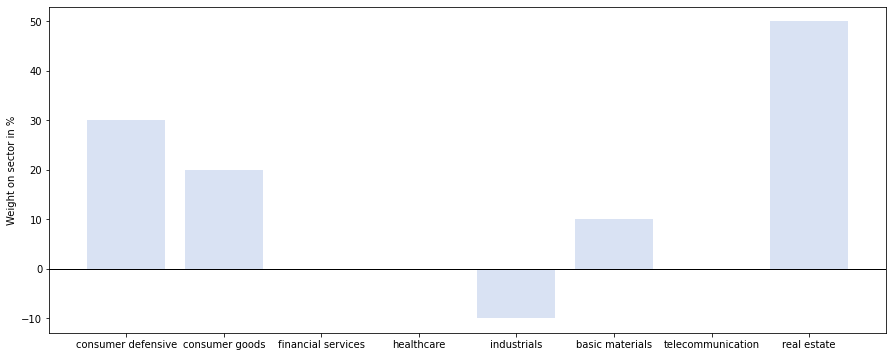

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(sectors, minvol_weights*100,color=['#d9e2f3'])
plt.ylabel('Weight on sector in %')
plt.axhline(y=0,linewidth=1, color='k')
plt.show()

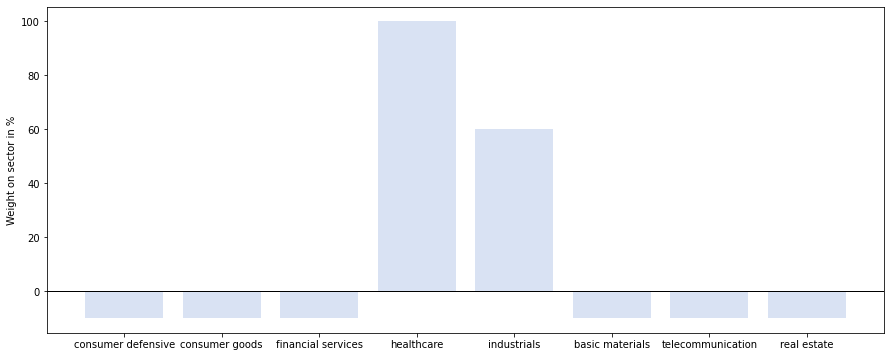

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(sectors, maxret_weights*100,color=['#d9e2f3'])
plt.ylabel('Weight on sector in %')
plt.axhline(y=0,linewidth=1, color='k')
plt.show()

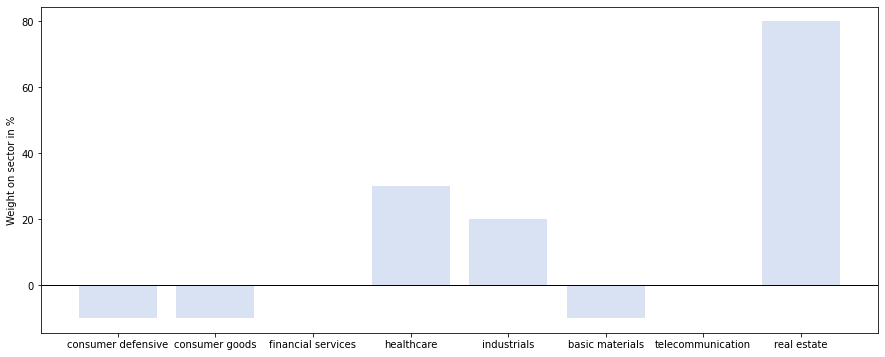

In [ ]:
plt.figure(figsize=(15,6))
plt.bar(sectors, maxsharpe_weights*100,color=['#d9e2f3'])
plt.ylabel('Weight on sector in %')
plt.axhline(y=0,linewidth=1, color='k')
plt.show()

In [ ]:
maxsharpe_df

,consumer defensive,consumer goods,healthcare,industrials,basic materials,real estate
0,-0.1,-0.1,0.3,0.2,-0.1,0.8


In [ ]:
maxret_df

,consumer defensive,consumer goods,financial services,healthcare,industrials,basic materials,telecommunication,real estate
0,-0.1,-0.1,-0.1,1.0,0.6,-0.1,-0.1,-0.1


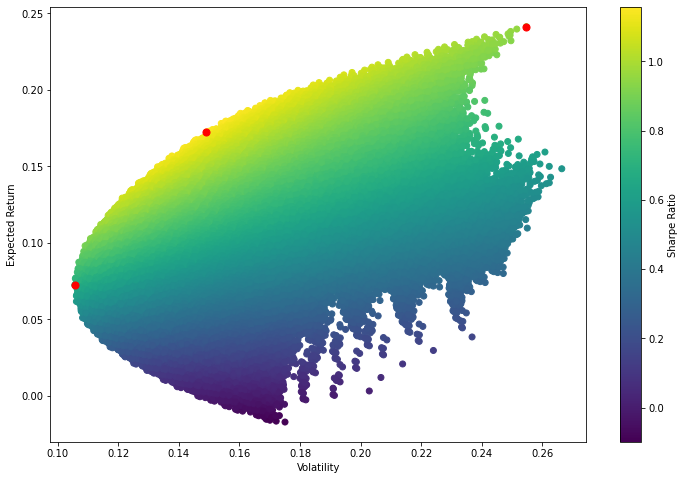

In [ ]:
#https://www.kaggle.com/code/trangthvu/efficient-frontier-optimization

plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Expected Return')
plt.scatter(max_vol_sr, max_ret_sr,c='red', s=50) # red dot
plt.scatter(minvol_vol_nr,minvol_ret_nr,c='red',s=50)
plt.scatter(maxret_vol,maxret_ret,c='red',s=50)
plt.show()

In [ ]:
def create_sector_returns(sector):
  data=pdr.get_data_yahoo(sector,start_test_quarter, end_test_quarter, progress=False )['Adj Close'] 
  ret=np.log(data / data.shift(1))[1:] 
  
  month_returns_array= pd.DataFrame(ret) 
  mra= month_returns_array.fillna(0)
  sector_ret=[] 
  for x in range(len(mra)):
    returns_data = len(mra.iloc[x,:].dropna())  #use the dropna, then calculate how many columns are left for every row. Do this so that the 0's don't pull down the average by dividing by the length of the total stocks, only dividing by those with non 0 values
    if returns_data == 0: #avoid dividing by 0
      returns_data = 1
    sector_ret.append(np.sum(mra.iloc[x,:])/returns_data)
  sec_ret=np.array(sector_ret) 
  return sec_ret

In [ ]:
post_opt_sectors_ret= np.column_stack((create_sector_returns(consumer_defensive),create_sector_returns(consumer_goods),create_sector_returns(financial_services),create_sector_returns(healthcare),create_sector_returns(industrials),create_sector_returns(basic_materials),create_sector_returns(telecommunication),create_sector_returns(real_estate)))
post_sectors_df=pd.DataFrame(post_opt_sectors_ret,columns=sectors)

In [ ]:
back_tested_maxret=maxret_weights*post_sectors_df.mean()*64 #64 trading days in that quarter
back_tested_minvol=minvol_weights*post_sectors_df.mean()*64
back_tested_maxsharpe=maxsharpe_weights*post_sectors_df.mean()*64


In [ ]:
list_of_rets_quarter=[]
list_of_rets_quarter.append(back_tested_minvol.sum()*100) #multiplty by 100 for percentages
list_of_rets_quarter.append(back_tested_maxsharpe.sum()*100)
list_of_rets_quarter.append(back_tested_maxret.sum()*100)
list_of_rets_quarter

[3.775152520985999, 3.028583050119802, -8.024082540128415]

In [ ]:
def create_sector_returns(sector):
  data=pdr.get_data_yahoo(sector,start_test_semester, end_test_semester, progress=False )['Adj Close'] 
  ret=np.log(data / data.shift(1))[1:] 
  
  month_returns_array= pd.DataFrame(ret) 
  mra= month_returns_array.fillna(0)
  sector_ret=[] 
  for x in range(len(mra)):
    returns_data = len(mra.iloc[x,:].dropna())  #use the dropna, then calculate how many columns are left for every row. Do this so that the 0's don't pull down the average by dividing by the length of the total stocks, only dividing by those with non 0 values
    if returns_data == 0: #avoid dividing by 0
      returns_data = 1
    sector_ret.append(np.sum(mra.iloc[x,:])/returns_data)
  sec_ret=np.array(sector_ret) 
  return sec_ret

In [ ]:
post_opt_sectors_ret= np.column_stack((create_sector_returns(consumer_defensive),create_sector_returns(consumer_goods),create_sector_returns(financial_services),create_sector_returns(healthcare),create_sector_returns(industrials),create_sector_returns(basic_materials),create_sector_returns(telecommunication),create_sector_returns(real_estate)))
post_sectors_df=pd.DataFrame(post_opt_sectors_ret,columns=sectors)

In [ ]:
back_tested_maxret=maxret_weights*post_sectors_df.mean()*125
back_tested_minvol=minvol_weights*post_sectors_df.mean()*125
back_tested_maxsharpe=maxsharpe_weights*post_sectors_df.mean()*125


In [ ]:
list_of_rets_semester=[]
list_of_rets_semester.append(back_tested_minvol.sum()*100)
list_of_rets_semester.append(back_tested_maxsharpe.sum()*100)
list_of_rets_semester.append(back_tested_maxret.sum()*100)
list_of_rets_semester


[-1.59643599488302, -0.06894923097230543, -7.272890442405568]

In [ ]:
def create_sector_returns(sector):
  data=pdr.get_data_yahoo(sector,start_test_annual, end_test_annual, progress=False )['Adj Close'] #.resample('M').ffill() 
  ret=np.log(data / data.shift(1))[1:] 
  
  month_returns_array= pd.DataFrame(ret) 
  mra= month_returns_array.fillna(0)
  sector_ret=[] 
  for x in range(len(mra)):
    returns_data = len(mra.iloc[x,:].dropna())  #use the dropna, then calculate how many columns are left for every row. Do this so that the 0's don't pull down the average by dividing by the length of the total stocks, only dividing by those with non 0 values
    if returns_data == 0: #avoid dividing by 0
      returns_data = 1
    sector_ret.append(np.sum(mra.iloc[x,:])/returns_data)
  sec_ret=np.array(sector_ret) 
  return sec_ret

In [ ]:
post_opt_sectors_ret= np.column_stack((create_sector_returns(consumer_defensive),create_sector_returns(consumer_goods),create_sector_returns(financial_services),create_sector_returns(healthcare),create_sector_returns(industrials),create_sector_returns(basic_materials),create_sector_returns(telecommunication),create_sector_returns(real_estate)))
post_sectors_df=pd.DataFrame(post_opt_sectors_ret,columns=sectors)

In [ ]:
 #254 trading days for the year 2017-2018
back_tested_minvol=minvol_weights*post_sectors_df.mean()*254
back_tested_maxsharpe=maxsharpe_weights*post_sectors_df.mean()*254
back_tested_maxret=maxret_weights*post_sectors_df.mean()*254



list_of_rets_annual=[]
list_of_rets_annual.append(back_tested_minvol.sum()*100)
list_of_rets_annual.append(back_tested_maxsharpe.sum()*100)
list_of_rets_annual.append(back_tested_maxret.sum()*100)
list_of_rets_annual

[0.981554215129625, 18.29393239074138, -3.6248757919756778]

In [ ]:
list_of_rets_quarter_arr=np.array(list_of_rets_quarter)
list_of_rets_semester_arr=np.array(list_of_rets_semester)
list_of_rets_annual_arr=np.array(list_of_rets_annual)
all_returns=np.column_stack((list_of_rets_quarter_arr,list_of_rets_semester_arr,list_of_rets_annual_arr))
all_returns

array([[ 3.77515252, -1.59643599,  0.98155422],
       [ 3.02858305, -0.06894923, 18.29393239],
       [-8.02408254, -7.27289044, -3.62487579]])

In [ ]:
all_returns_df=pd.DataFrame(all_returns,index=["minvol","maxsharpe","maxret"],columns=["quarter","semester","annual"])
all_returns_df

,quarter,semester,annual
minvol,3.775153,-1.596436,0.981554
maxsharpe,3.028583,-0.068949,18.293932
maxret,-8.024083,-7.272890,-3.624876


In [ ]:
data=pdr.get_data_yahoo("^MDAXI",start_test_quarter, end_test_quarter, progress=False )['Adj Close'].pct_change()[1:] #.resample('M').ffill() 
quarter_index=data.cumsum()[-1]
data1=pdr.get_data_yahoo("^MDAXI",start_test_semester, end_test_semester, progress=False )['Adj Close'].pct_change()[1:] #.resample('M').ffill() 
semester_index=data1.cumsum()[-1]
data2=pdr.get_data_yahoo("^MDAXI",start_test_annual, end_test_annual, progress=False )['Adj Close'].pct_change()[1:] #.resample('M').ffill() 
annual_index=data2.cumsum()[-1]

In [ ]:
index_returns=[]
index_returns.append(quarter_index)
index_returns.append(semester_index)
index_returns.append(annual_index)
index_returns_array=np.array(index_returns)
index_returns_array

array([0.04118355, 0.01266763, 0.03999222])

In [ ]:
alpha_quarter=(list_of_rets_quarter_arr/100 -quarter_index)*100
alpha_semester=(list_of_rets_semester_arr/100 -semester_index)*100
alpha_annual=(list_of_rets_annual_arr/100 -annual_index)*100

In [ ]:
Metrics=["Expected Return","Volatility","Sharpe Ratio","Actual Return","Outperformance of Index"]


In [ ]:
minvol_criteria_quarter=[]
minvol_criteria_quarter.append(minvol_ret_nr)
minvol_criteria_quarter.append(minvol_vol_nr)
minvol_criteria_quarter.append(minvol_sharpe)
minvol_criteria_quarter.append(list_of_rets_quarter_arr[0])
minvol_criteria_quarter.append(alpha_quarter[0])    
minvol_criteria_quarter_array=np.array(minvol_criteria_quarter)



maxsharpe_criteria_quarter=[]
maxsharpe_criteria_quarter.append(max_ret_sr)
maxsharpe_criteria_quarter.append(max_vol_sr)
maxsharpe_criteria_quarter.append(max_sharpe_sr)
maxsharpe_criteria_quarter.append(list_of_rets_quarter_arr[1]) 
maxsharpe_criteria_quarter.append(alpha_quarter[1])    
maxsharpe_criteria_quarter_array=np.array(maxsharpe_criteria_quarter)


maxret_criteria_quarter=[]
maxret_criteria_quarter.append(maxret_ret)
maxret_criteria_quarter.append(maxret_vol)
maxret_criteria_quarter.append(maxret_sharpe)
maxret_criteria_quarter.append(list_of_rets_quarter_arr[2])
maxret_criteria_quarter.append(alpha_quarter[2])    
maxret_criteria_quarter_array=np.array(maxret_criteria_quarter)

In [ ]:
maxret_criteria_quarter

[0.24135215154347103,
 0.254724568659329,
 0.9475024447534058,
 -8.024082540128415,
 -12.142437148113512]

In [ ]:
minvol_criteria_semester=[]
minvol_criteria_semester.append(minvol_ret_nr)
minvol_criteria_semester.append(minvol_vol_nr)
minvol_criteria_semester.append(minvol_sharpe)
minvol_criteria_semester.append(list_of_rets_semester_arr[0])
minvol_criteria_semester.append(alpha_semester[0])    
minvol_criteria_semester_array=np.array(minvol_criteria_semester)



maxsharpe_criteria_semester=[]
maxsharpe_criteria_semester.append(max_ret_sr)
maxsharpe_criteria_semester.append(max_vol_sr)
maxsharpe_criteria_semester.append(max_sharpe_sr)
maxsharpe_criteria_semester.append(list_of_rets_semester_arr[1]) 
maxsharpe_criteria_semester.append(alpha_semester[1])    
maxsharpe_criteria_semester_array=np.array(maxsharpe_criteria_semester)


maxret_criteria_semester=[]
maxret_criteria_semester.append(maxret_ret)
maxret_criteria_semester.append(maxret_vol)
maxret_criteria_semester.append(maxret_sharpe)
maxret_criteria_semester.append(list_of_rets_semester_arr[2])
maxret_criteria_semester.append(alpha_semester[2])    
maxret_criteria_semester_array=np.array(maxret_criteria_semester)

In [ ]:
minvol_criteria_annual=[]
minvol_criteria_annual.append(minvol_ret_nr)
minvol_criteria_annual.append(minvol_vol_nr)
minvol_criteria_annual.append(minvol_sharpe)
minvol_criteria_annual.append(list_of_rets_annual_arr[0])
minvol_criteria_annual.append(alpha_annual[0])    
minvol_criteria_annual_array=np.array(minvol_criteria_annual)



maxsharpe_criteria_annual=[]
maxsharpe_criteria_annual.append(max_ret_sr)
maxsharpe_criteria_annual.append(max_vol_sr)
maxsharpe_criteria_annual.append(max_sharpe_sr)
maxsharpe_criteria_annual.append(list_of_rets_annual_arr[1]) #,list_of_rets_annual_arr[1])
maxsharpe_criteria_annual.append(alpha_annual[1])    
maxsharpe_criteria_annual_array=np.array(maxsharpe_criteria_annual)


maxret_criteria_annual=[]
maxret_criteria_annual.append(maxret_ret)
maxret_criteria_annual.append(maxret_vol)
maxret_criteria_annual.append(maxret_sharpe)
maxret_criteria_annual.append(list_of_rets_annual_arr[2])
maxret_criteria_annual.append(alpha_annual[2])    
maxret_criteria_annual_array=np.array(maxret_criteria_annual)

In [ ]:
maxret_criteria_annual

[0.24135215154347103,
 0.254724568659329,
 0.9475024447534058,
 -3.6248757919756778,
 -7.624097736482381]

In [ ]:
metro_boomin=np.column_stack((minvol_criteria_quarter_array,maxsharpe_criteria_quarter_array,maxret_criteria_quarter_array))
metrics_df_quarter=pd.DataFrame(metro_boomin,index=Metrics,columns=["Minimum Volatility","Maximum Sharpe Ratio ","Maximum Expected Return"])

wants=np.column_stack((minvol_criteria_semester_array,maxsharpe_criteria_semester_array,maxret_criteria_semester_array))
metrics_df_semester=pd.DataFrame(wants,index=Metrics,columns=["minvol","maxsharpe","maxret"])

some_more=np.column_stack((minvol_criteria_annual_array,maxsharpe_criteria_annual_array,maxret_criteria_annual_array))
metrics_df_annual=pd.DataFrame(some_more,index=Metrics,columns=["minvol","maxsharpe","maxret"])


In [ ]:
metrics_df_quarter

,Minimum Volatility,Maximum Sharpe Ratio,Maximum Expected Return
Expected Return,0.072380,0.172516,0.241352
Volatility,0.105662,0.149115,0.254725
Sharpe Ratio,0.685014,1.156935,0.947502
Actual Return,3.775153,3.028583,-8.024083
Outperformance of Index,-0.343202,-1.089772,-12.142437


In [ ]:
metrics_df_semester

,minvol,maxsharpe,maxret
Expected Return,0.072380,0.172516,0.241352
Volatility,0.105662,0.149115,0.254725
Sharpe Ratio,0.685014,1.156935,0.947502
Actual Return,-1.596436,-0.068949,-7.272890
Outperformance of Index,-2.863199,-1.335712,-8.539653


In [ ]:
metrics_df_annual

,minvol,maxsharpe,maxret
Expected Return,0.072380,0.172516,0.241352
Volatility,0.105662,0.149115,0.254725
Sharpe Ratio,0.685014,1.156935,0.947502
Actual Return,0.981554,18.293932,-3.624876
Outperformance of Index,-3.017668,14.294710,-7.624098


<AxesSubplot:>

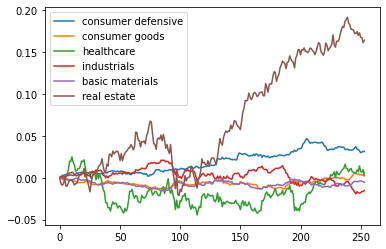

In [ ]:
#https://datatofish.com/select-rows-pandas-dataframe/
maxsharpe_ret=post_sectors_df*maxsharpe_weights
maxsharpe_ret.loc[:, (maxsharpe_ret != 0).any(axis=0)].cumsum().plot()

In [ ]:
maxsharpe_ret.loc[:, (maxsharpe_ret != 0).any(axis=0)].cumsum(axis=0)
maxret_ret=post_sectors_df*maxret_weights
minvol_ret=post_sectors_df*minvol_weights
henro=[]
henry=[]
henrie=[]
for x in range(len(maxsharpe_ret)):
  henro.append(maxsharpe_ret.cumsum(axis=0).loc[x].sum())
henro_df=pd.DataFrame(henro)
for x in range(len(maxret_ret)):
  henry.append(maxret_ret.cumsum(axis=0).loc[x].sum())
henry_df=pd.DataFrame(henry)
for x in range(len(minvol_ret)):
  henrie.append(minvol_ret.cumsum(axis=0).loc[x].sum())
henrie_df=pd.DataFrame(henrie)

<AxesSubplot:>

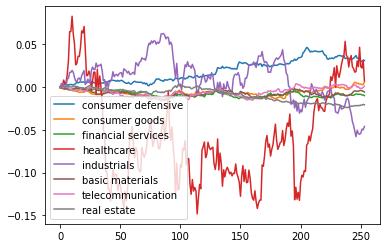

In [ ]:
maxret_ret.loc[:, (maxret_ret != 0).any(axis=0)].cumsum().plot()

<AxesSubplot:>

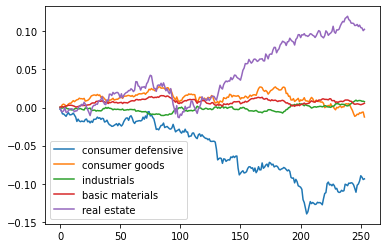

In [ ]:
minvol_ret.loc[:, (minvol_ret != 0).any(axis=0)].cumsum().plot()

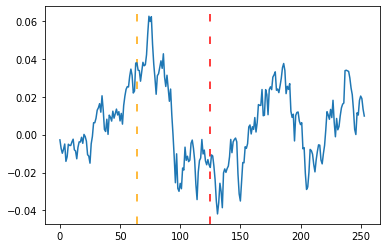

In [ ]:
fig=plt.figure()
plt.axvline(x=64,linestyle=(0, (5,10)),color='orange')
plt.axvline(x=125,linestyle=(0, (5,10)),color='red')
plt.plot(henrie_df)

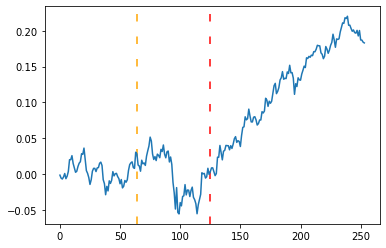

In [ ]:
#https://matplotlib.org/stable/gallery/lines_bars_and_markers/linestyles.html
#https://stackoverflow.com/questions/24988448/how-to-draw-vertical-lines-on-a-given-plot
fig=plt.figure()
plt.axvline(x=64,linestyle=(0, (5,10)),color='orange')
plt.axvline(x=125,linestyle=(0, (5,10)),color='red')
plt.plot(henro_df)


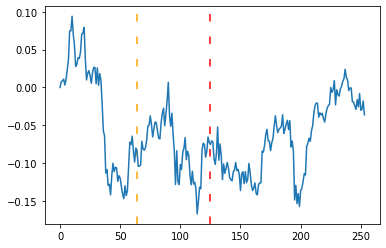

In [ ]:
fig=plt.figure()
plt.axvline(x=64,linestyle=(0, (5,10)),color='orange')
plt.axvline(x=125,linestyle=(0, (5,10)),color='red')
plt.plot(henry_df)

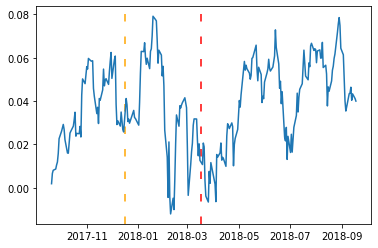

In [ ]:
fig=plt.figure()
plt.axvline(x=17517,linestyle=(0, (5,10)),color='orange') #Days for Quarter and Half year as taken from date of MDAX
plt.axvline(x=17607,linestyle=(0, (5,10)),color='red')
plt.plot(data2.cumsum())